# Kaggle Tabular Playground Series - May 2021
> "A notebook for the Kaggle Tabular Playground Series - May 2021"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [jupyter, kaggle, tabular, CatBoost, classification, Complete]
- hide: false

### Objective:

I wanted to get into the habit of seriously taking part in some Kaggle competetions. The Tabluar Playground Series seemed like a good place to start. The competetion for May 2021 involves a multi-class classification problem for a consumer products dataset. The dataset was a bit skewed and quite sparse with many features. I tried a few models and learnt quite a bit from the notebooks and the discussion forums. This post is basically a walkthrough of my approach to tackle this problem. 

In [ ]:
#hide
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json

api_token = {"username":"nitinkashyap","key":"b0a54ce5183e803af6428bfa11d5c539"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-may-2021

  0% 0.00/1.72M [00:00<?, ?B/s]
100% 1.72M/1.72M [00:00<00:00, 57.7MB/s]
  0% 0.00/851k [00:00<?, ?B/s]
100% 851k/851k [00:00<00:00, 121MB/s]
  0% 0.00/128k [00:00<?, ?B/s]
100% 128k/128k [00:00<00:00, 133MB/s]


In [ ]:
import pandas as pd
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip') 
sample_submission = pd.read_csv('sample_submission.csv.zip')

In [ ]:
train[45:50]

id  feature_0  feature_1  ...  feature_48  feature_49   target
45  45          0          0  ...           0           1  Class_2
46  46          0          0  ...           1           0  Class_2
47  47          0          0  ...           0           0  Class_1
48  48          0          0  ...           0           1  Class_3
49  49          0          0  ...           0           1  Class_2

[5 rows x 52 columns]

### Exploratory Data Analysis

Lets do some EDA to get a sense of the data

In [ ]:
#collapse-output
train.describe()

id      feature_0  ...    feature_49        target2
count  100000.000000  100000.000000  ...  100000.00000  100000.000000
mean    49999.500000       0.257830  ...       0.55712       1.381160
std     28867.657797       0.929033  ...       1.68093       0.810891
min         0.000000       0.000000  ...       0.00000       0.000000
25%     24999.750000       0.000000  ...       0.00000       1.000000
50%     49999.500000       0.000000  ...       0.00000       1.000000
75%     74999.250000       0.000000  ...       0.00000       2.000000
max     99999.000000      10.000000  ...      20.00000       3.000000

[8 rows x 52 columns]

It appears that the data is very sparse and fortunately contains no null values. We will need to do some dimensiontionality reduction ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)) and pick the best features to reduce the noise in the input dataset. 

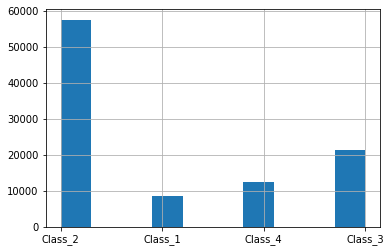

In [ ]:
train['target'].hist()

Looks like Class_2 has a lot more data points than the other 3 classes combined. This is a pretty skewed datset and will bias the classifier, I am thinking of using SMOTE to handle the issue of class imbalance in the dataset.

In [ ]:
(train == 0).sum().sum()/(train.shape[0]*train.shape[1])*100

76.35163461538461

Another thing I noticed was that 75 % of the data values are 0s, so the dataset is very sparse. Lets get started and build a small simple model. Firstly we will clean up the datasets and create the variables necessary to start on building the model.

In [ ]:
train.target = pd.Categorical(train.target)
train['target2'] = train.target.cat.codes

from sklearn.model_selection import train_test_split
indep_vars = ['feature_' + str(i) for i in range(50)]
dep_var = ['target2']

X = train[indep_vars].to_numpy()
y = train[dep_var].to_numpy().ravel()


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = test[indep_vars].to_numpy()

### Naive Baseline Model - Random Forest

Here we are building a simple model using a RandomForest classifier. The main purpose of this is to get a baseline perfromance and also identify key features that can be used for later analyses.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_samples=70000,
       max_features=0.5, min_samples_leaf=5, oob_score=True)

rf.fit(X_train, y_train)
rf.score(X_valid, y_valid)

0.5757

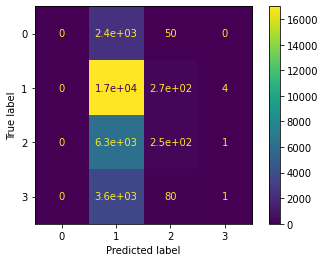

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_valid, y_valid)

In [ ]:
rf.predict_proba(X_test)

array([[0.14013549, 0.5686321 , 0.14980887, 0.14142354],
       [0.0913934 , 0.68614493, 0.16746077, 0.0550009 ],
       [0.05243985, 0.61068121, 0.20493451, 0.13194442],
       ...,
       [0.09103053, 0.54871624, 0.20957293, 0.1506803 ],
       [0.04416667, 0.65122176, 0.15509768, 0.14951389],
       [0.13996562, 0.51813905, 0.23093735, 0.11095798]])

As expected the model does not perform very well and most of the classes are mis-classified in favour of the majority class here. Let's see how well this did on Kaggle

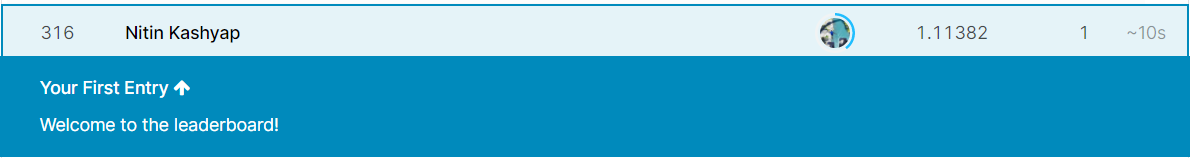

#### SMOTE:

To deal with the class imbalance issue, I decide to try out SMOTE and see if the helps in the prediction.

In [ ]:
from imblearn.over_sampling import  KMeansSMOTE
ros =  KMeansSMOTE(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

rf_SMOTE = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_samples=70000,
       max_features=0.5, min_samples_leaf=5, oob_score=True)

rf_SMOTE.fit(X_train, y_train)
print(rf_SMOTE.score(X_train, y_train))
rf_SMOTE.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_SMOTE, X_valid, y_valid)

In [ ]:
submission2 = submissionFile(rf_SMOTE, generate_csv=True)

In [ ]:
!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "SMOTE Oversampling - Randomforests"

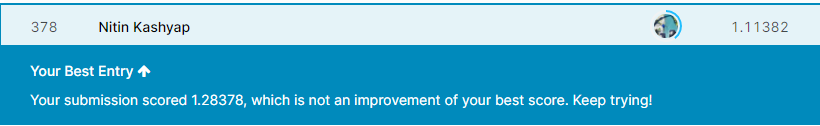

Unfortunately SMOTE did not help improve the quality of the predictions.

### CatBoost

After trying PCA and SMOTE after tweaking the parameters and getting worse predictions than the simpleRandom Forests mosel. I came across the CatBoost Calssifier from one of the notebooks on Kaggle. 




In [ ]:
#hide
!pip install catboost


     |████████████████████████████████| 67.3MB 42kB/s 


In [ ]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
def train_models(df, columns, cat_features, random_state, n_splits):

    models = []
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True,
                            random_state=random_state)  # create folds
    X_train = df[columns]
    y_train = df['target']
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,  y_train)):
        print('Fold {}/{}'.format(n_fold, n_splits))
        train_X, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_X, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        dataset = Pool(train_X, train_y, cat_features)
        evalset = Pool(valid_X, valid_y, cat_features)
        model = CatBoostClassifier(
            task_type="GPU",
            depth=4,
            max_ctr_complexity=15,
            # border_count=1024,
            iterations=50000,
            od_wait=1000, od_type='Iter',
            # l2_leaf_reg=0.01,
            learning_rate=0.01,
            min_data_in_leaf=1,
            use_best_model=True,
            loss_function='MultiClass'

        )
        model.fit(dataset, plot=False, verbose=500, eval_set=evalset)        
        _record = {
            'model': model,
        }
        models.append(_record)

    return models


In [ ]:
#collapse-output
models = train_models(df=train, columns=indep_vars, cat_features=indep_vars, random_state=43, n_splits=9)

Fold 0/9
0:	learn: 1.3803258	test: 1.3803090	best: 1.3803090 (0)	total: 14.2ms	remaining: 11m 52s
500:	learn: 1.1015525	test: 1.1040991	best: 1.1040991 (500)	total: 4.32s	remaining: 7m 6s
1000:	learn: 1.0941982	test: 1.0985177	best: 1.0985177 (1000)	total: 8.64s	remaining: 7m 3s
1500:	learn: 1.0898579	test: 1.0957048	best: 1.0957048 (1500)	total: 12.8s	remaining: 6m 52s
2000:	learn: 1.0868512	test: 1.0941372	best: 1.0941372 (2000)	total: 16.8s	remaining: 6m 43s
2500:	learn: 1.0844617	test: 1.0931781	best: 1.0931781 (2500)	total: 21.1s	remaining: 6m 41s
3000:	learn: 1.0825322	test: 1.0925268	best: 1.0925268 (3000)	total: 25.3s	remaining: 6m 35s
3500:	learn: 1.0808074	test: 1.0920747	best: 1.0920747 (3500)	total: 29.4s	remaining: 6m 30s
4000:	learn: 1.0792429	test: 1.0916825	best: 1.0916766 (3997)	total: 33.4s	remaining: 6m 24s
4500:	learn: 1.0778355	test: 1.0914039	best: 1.0914028 (4487)	total: 37.5s	remaining: 6m 19s
5000:	learn: 1.0764980	test: 1.0912250	best: 1.0912243 (4994)	total: 

In [ ]:
#hide
def submissionFile(modelZ, generate_csv=True):  # 4d 
    probabilities = pd.DataFrame(modelZ.predict_proba(X_test), columns=['Class_1','Class_2','Class_3','Class_4'])
    mySubmission = pd.DataFrame()
    mySubmission['id'] = test['id']
    mySubmission['Class_1'] = probabilities['Class_1']
    mySubmission['Class_2'] = probabilities['Class_2']
    mySubmission['Class_3'] = probabilities['Class_3']
    mySubmission['Class_4'] = probabilities['Class_4']
    if generate_csv:
        mySubmission.to_csv('submission.csv', index=False)
    return mySubmission

Picking model 3 which had the lowest loss

In [ ]:
models[2]['model'].predict_proba(X_train)
submissionFile(models[3]['model'])
!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "CatBoost-Classifier"

100% 4.06M/4.06M [00:01<00:00, 2.22MB/s]
Successfully submitted to Tabular Playground Series - May 2021

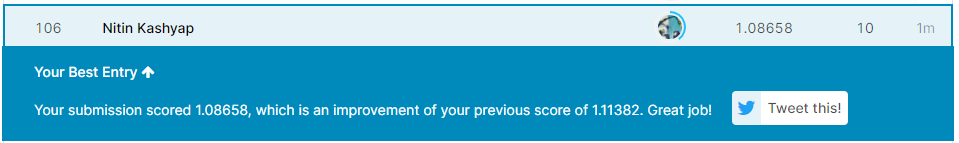

This model gave us the best performance. I will now try to improve the performance using some feature engineering and feature 

In [ ]:
#hide
for i in indep_vars:
    if ((len(test[i].unique())) > (len(train[i].unique()))):
            
        print(i)
        print(len(train[i].unique()))
        print(len(test[i].unique()))
    

feature_1
31
32
feature_37
15
16
feature_40
22
24
feature_45
27
28
feature_47
26
27


In [ ]:
cat_vars = []
num_vars = []
for i in indep_vars:
    unique = list(train[i].unique())
    unique.sort()
    if (unique[-1] == (len(unique) -1)):
        cat_vars.append(i)
    else:
        num_vars.append(i)

print(cat_vars)
print(num_vars)

['feature_0', 'feature_2', 'feature_5', 'feature_6', 'feature_7', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_20', 'feature_22', 'feature_23', 'feature_24', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_40', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49']
['feature_1', 'feature_3', 'feature_4', 'feature_8', 'feature_19', 'feature_21', 'feature_25', 'feature_30', 'feature_31', 'feature_32', 'feature_38', 'feature_39', 'feature_41', 'feature_42', 'feature_43']


Using t a proxy to see if the number of levels is equal to the number of unique elements in the list and using numberical varaible sfor the others.

In [ ]:
#collapse-output
models = train_models(df=train, columns=indep_vars, cat_features=cat_vars, random_state=43, n_splits=9)

Fold 0/9
0:	learn: 1.3803154	test: 1.3802907	best: 1.3802907 (0)	total: 16ms	remaining: 13m 21s
500:	learn: 1.1014573	test: 1.1042078	best: 1.1042078 (500)	total: 4.62s	remaining: 7m 36s
1000:	learn: 1.0941843	test: 1.0986681	best: 1.0986681 (1000)	total: 8.94s	remaining: 7m 17s
1500:	learn: 1.0897845	test: 1.0957679	best: 1.0957679 (1500)	total: 13.2s	remaining: 7m 5s
2000:	learn: 1.0866740	test: 1.0941196	best: 1.0941196 (2000)	total: 17.5s	remaining: 6m 59s
2500:	learn: 1.0842484	test: 1.0931565	best: 1.0931552 (2499)	total: 21.7s	remaining: 6m 51s
3000:	learn: 1.0821899	test: 1.0924521	best: 1.0924521 (3000)	total: 25.9s	remaining: 6m 45s
3500:	learn: 1.0803967	test: 1.0919472	best: 1.0919445 (3492)	total: 30s	remaining: 6m 39s
4000:	learn: 1.0787984	test: 1.0915882	best: 1.0915839 (3992)	total: 34.2s	remaining: 6m 33s
4500:	learn: 1.0773583	test: 1.0912775	best: 1.0912775 (4500)	total: 38.4s	remaining: 6m 28s
5000:	learn: 1.0759195	test: 1.0910710	best: 1.0910687 (4994)	total: 42.

In [ ]:
for model in models:
    print(model['model'].get_best_score())

{'learn': {'MultiClass': 1.0646599337087121}, 'validation': {'MultiClass': 1.090453574260934}}
{'learn': {'MultiClass': 1.0637241390948262}, 'validation': {'MultiClass': 1.090042472690352}}
{'learn': {'MultiClass': 1.0582702689590389}, 'validation': {'MultiClass': 1.0876823221357212}}
{'learn': {'MultiClass': 1.0587420652442934}, 'validation': {'MultiClass': 1.088606677082396}}
{'learn': {'MultiClass': 1.0613538197921002}, 'validation': {'MultiClass': 1.0920375219377194}}
{'learn': {'MultiClass': 1.065104195963505}, 'validation': {'MultiClass': 1.0913909920349203}}
{'learn': {'MultiClass': 1.066106675179156}, 'validation': {'MultiClass': 1.0922525924477995}}
{'learn': {'MultiClass': 1.0573636782954021}, 'validation': {'MultiClass': 1.0909432727139772}}
{'learn': {'MultiClass': 1.062833280833399}, 'validation': {'MultiClass': 1.0916937782659077}}


In [ ]:
grid = {'learning_rate': [0.03, 0.01, 0.001, 0.1],
        'depth': [4, 6, 10],
        'max_ctr_complexity': [10, 15, 30]}


for model in models:
    print(model['model'].get_best_score())
    grid_search_result = model['model'].grid_search(grid, 
                                       X=train, 
                                       y=train_labels, 
                                       plot=True)

In [ ]:
#collapse-output
X_train = train[indep_vars]
y_train = train['target']
#for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,  y_train)):
#    print('Fold {}/{}'.format(n_fold, n_splits))
dataset = Pool(X_train, y_train, indep_vars)
model_2 = CatBoostClassifier(
    task_type="GPU",
    iterations=15000,
    od_wait=1000, od_type='Iter',
    min_data_in_leaf=1,
    loss_function='MultiClass'

)
grid = {'learning_rate': [0.03, 0.01, 0.001, 0.1],
'depth': [4, 6, 10],
'max_ctr_complexity': [10, 15, 30]}

grid_search_result = model_2.grid_search(grid, dataset, cv=10,
                                plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
13938:	learn: 1.0766900	test: 1.0987451	best: 1.0987451 (13937)	total: 4m 4s	remaining: 18.6s
13939:	learn: 1.0766886	test: 1.0987441	best: 1.0987441 (13939)	total: 4m 4s	remaining: 18.6s
13940:	learn: 1.0766870	test: 1.0987442	best: 1.0987441 (13939)	total: 4m 4s	remaining: 18.6s
13941:	learn: 1.0766857	test: 1.0987438	best: 1.0987438 (13941)	total: 4m 4s	remaining: 18.5s
13942:	learn: 1.0766839	test: 1.0987435	best: 1.0987435 (13942)	total: 4m 4s	remaining: 18.5s
13943:	learn: 1.0766825	test: 1.0987437	best: 1.0987435 (13942)	total: 4m 4s	remaining: 18.5s
13944:	learn: 1.0766819	test: 1.0987436	best: 1.0987435 (13942)	total: 4m 4s	remaining: 18.5s
13945:	learn: 1.0766812	test: 1.0987438	best: 1.0987435 (13942)	total: 4m 4s	remaining: 18.5s
13946:	learn: 1.0766803	test: 1.0987434	best: 1.0987434 (13946)	total: 4m 4s	remaining: 18.5s
13947:	learn: 1.0766791	test: 1.0987432	best: 1.0987432 (13947)	total: 4m 4s	remaining: 18.4s
13948:	le

In [ ]:
models[3]['model'].predict_proba(X_train)
submissionFile(models[3]['model'])
!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "CatBoost-Classifier-CatvsNum"

100% 4.06M/4.06M [00:02<00:00, 1.54MB/s]
Successfully submitted to Tabular Playground Series - May 2021

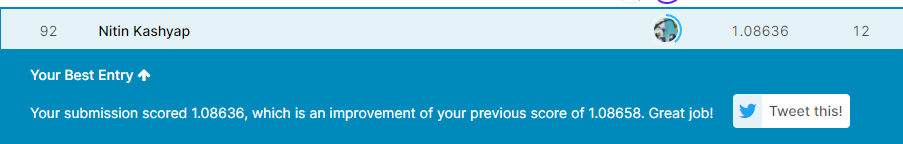

Look at scaling the non categorical features in this to. 



In [ ]:
train2 = train.copy()
train2[num_vars].describe()

feature_1      feature_3  ...     feature_42     feature_43
count  100000.000000  100000.000000  ...  100000.000000  100000.000000
mean        0.431720       0.590550  ...       0.529230       0.616310
std         1.977862       1.844558  ...       2.300826       2.360955
min         0.000000       0.000000  ...      -2.000000       0.000000
25%         0.000000       0.000000  ...       0.000000       0.000000
50%         0.000000       0.000000  ...       0.000000       0.000000
75%         0.000000       0.000000  ...       0.000000       0.000000
max        31.000000      26.000000  ...      37.000000      33.000000

[8 rows x 15 columns]

In [ ]:
for i in num_vars:
    a = list(train2[i].unique())
    a.sort()
    print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 39]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

Maybe just choosing the negative numbers as numeric will help imporve the predictions

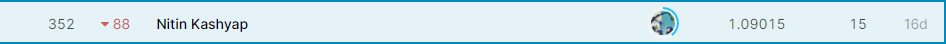

Had some other professional commitments come up and couldn't work in this as much as ai would have liked. Will try to do better in the June Competerion

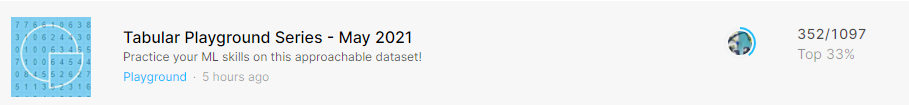

# Appendix
Here some some attempts and model modifications that did not yeild any improvements:

### Principal Component Analysis

While going throu

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)

In [ ]:
import seaborn as sns
sns.barplot(x=[i for i in range(50)], y=pca.explained_variance_ratio_)

In [ ]:
vars = list(pca.explained_variance_ratio_)
sum(vars[:35])

So 95% of the variance is explained by 35 factors. We can run PCA again to reduce the dimensionality to 35 from 50

In [ ]:
pca_35 = PCA(n_components=35)
X_35 = pca_35.fit_transform(X)

### UMAP (Universal Manifold Approximation and Projection)

UMAP is a dimesion reduction method that can be used to visualize data in multi dimensions. It is based on the following assumptions.
- Data is uniformly distributed on Reimannian manifold
- 
-


n= 4 to see if we can map directly to classes

In [ ]:
!pip install umap-learn
import umap

In [ ]:
umapD = umap.UMAP(n_neighbors=10 ,n_components=35)
train_4d = umapD.fit_transform(X)
test_4d = umapD.fit_transform(X_test)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_4d, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_umap = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_samples=70000,
       max_features=0.5, min_samples_leaf=5, oob_score=True)

rf_umap.fit(X_train, y_train)
print(rf_umap.score(X_train, y_train))
print(rf_umap.score(X_valid, y_valid))

0.7767428571428572
0.5609333333333333


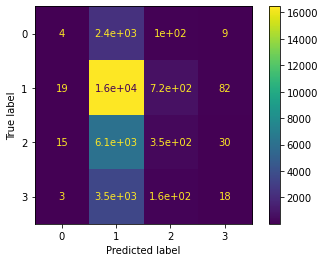

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_umap, X_valid, y_valid)

In [ ]:
def submissionFile(modelZ, generate_csv=True):  # 4d 
    probabilities = pd.DataFrame(modelZ.predict_proba(test_4d), columns=['Class_1','Class_2','Class_3','Class_4'])
    mySubmission = pd.DataFrame()
    mySubmission['id'] = test['id']
    mySubmission['Class_1'] = probabilities['Class_1']
    mySubmission['Class_2'] = probabilities['Class_2']
    mySubmission['Class_3'] = probabilities['Class_3']
    mySubmission['Class_4'] = probabilities['Class_4']
    if generate_csv:
        mySubmission.to_csv('submission.csv', index=False)
    return mySubmission

In [ ]:
submissionFile(rf_umap, True)
!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "Test-RF-Classifier"

100% 4.06M/4.06M [00:02<00:00, 2.01MB/s]
Successfully submitted to Tabular Playground Series - May 2021

### Oversampling

One thing 

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [ ]:

rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_samples=70000,
       max_features=0.5, min_samples_leaf=5, oob_score=True)

rf2.fit(X_train, y_train)

rf2.score(X_train, y_train)
rf2.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf2, X_valid, y_valid)

In [ ]:
model.predict_proba(X_test)

In [ ]:
submission2 = submissionFile(rf2, generate_csv=True)

In [ ]:
!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "Random Oversampling - Randomforests"

Unfortunately did much more poorly on the test set. Most likely overfit here:
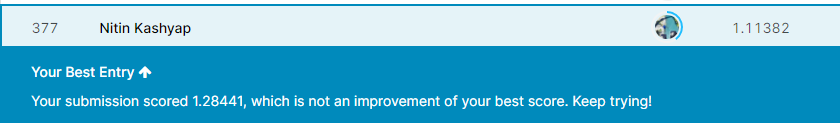

### Undersampling




In [ ]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

rf_rus = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_samples=20000,
       max_features=0.5, min_samples_leaf=5, oob_score=True)

rf_rus.fit(X_train, y_train)
print(rf_rus.score(X_train, y_train))
rf_rus.score(X_valid, y_valid)

Definitely Overfit here, the score in training is over 90 but less than half that in the validation set.

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_rus, X_valid, y_valid)

In [ ]:
submission2 = submissionFile(rf_rus, generate_csv=True)

### Bagging Classifier

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

brf = EasyEnsembleClassifier(random_state=42)
brf.fit(X_train, y_train) 


In [ ]:
print(brf.score(X_train, y_train))
brf.score(X_valid, y_valid)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(brf, X_valid, y_valid)

### Combination of Over and Undersampling

In [ ]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

rf_smoteEEN = RandomForestClassifier(n_jobs=-1, n_estimators=40, max_samples=70000,
       max_features=0.5, min_samples_leaf=5, oob_score=True)

rf_smoteEEN.fit(X_train, y_train)
print(rf_smoteEEN.score(X_train, y_train))
rf_smoteEEN.score(X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

0.9208717740073235


0.7399358563181526

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_smoteEEN, X_valid, y_valid)

### Baseline model - SVM

To tackle the sparseness part, I will take a look at using Support Vector Machines.

In [ ]:
train_sub = train.sample(10000, random_state=2)

In [ ]:
proj_4d

In [ ]:
from umap import UMAP

train_sub = train.sample(10000, random_state=0)
target = train_sub['target2']
umap = UMAP(random_state=0)
dr = umap.fit_transform(train_sub[indep_vars].iloc[:,:-1], target)

In [ ]:
import plotly.express as px
fig_2d = px.scatter(
    dr, x=0, y=1, 
    labels={'color': 'target'},
    color=train_sub.target,
    color_discrete_sequence=px.colors.qualitative.G10,
)

fig_2d.show()

In [ ]:
import plotly.express as px
fig_2d = px.scatter(
    proj_4d, x=0, y=1, 
    labels={'color': 'target'},
    color=train[''],
    color_discrete_sequence=px.colors.qualitative.G10,
)

fig_2d.show()

In [ ]:
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit_transform(train_sub[indep_vars])
fig_mapper = px.scatter(
    mapper, x=0, y=1, 
    labels={'color': 'target'},
    color=train_sub.target,
    color_discrete_sequence=px.colors.qualitative.G10,
)

fig_mapper.show()

In [ ]:
from sklearn import svm
clf = svm.SVC()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf.fit(X_train, y_train)
clf.score(X_valid, y_valid)

### Using the top important features only

In [ ]:
imps = pd.DataFrame({'cols':indep_vars, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
imps[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
plot_fi(imps[:30])

In [ ]:
# Choosing the top 20 features
imp_features = imps[imps.imp>0.015].cols
len(imp_features)

In [ ]:
X2 = (train[imp_features].to_numpy())
X2_test = test[imp_features].to_numpy()

model2 = rf(X2,y)
model2.predict_proba(X2_test)

In [ ]:
#submission2 = submissionFile(model2, generate_csv=True)

In [ ]:
#!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "Top10 Features"

### Generate the submission

In [ ]:
def submissionFile(modelZ, generate_csv=True):
    probabilities = pd.DataFrame(modelZ.predict_proba(X_test), columns=['Class_1','Class_2','Class_3','Class_4'])
    mySubmission = pd.DataFrame()
    mySubmission['id'] = test['id']
    mySubmission['Class_1'] = probabilities['Class_1']
    mySubmission['Class_2'] = probabilities['Class_2']
    mySubmission['Class_3'] = probabilities['Class_3']
    mySubmission['Class_4'] = probabilities['Class_4']
    if generate_csv:
        mySubmission.to_csv('submission.csv', index=False)
    return mySubmission

In [ ]:
#submissionFile(model, True)
#!kaggle competitions submit -c tabular-playground-series-may-2021 -f submission.csv -m "Test-RF-Classifier"